In [339]:
from gymnasium import Env
from gymnasium.spaces import Box, Dict, Discrete, MultiDiscrete
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from copy import copy
import ray

In [340]:
class Architecture:
    def __init__(self):
        self.c_capacity, self.s_capacity = 50, 2
        self.weights = [0.0125, 0.0010, 0.0200, 0.5000] # REVIEW
        self.lifetime = {0: 1, 1: 2, 2: 3, 3: 10}   # REVIEW
        self.max_actions = 10
        self.num_c = 2
        self.num_s = 10
        self.max_actions = 10
        self.min_free_space = 0.2
        self.space_flag = -1

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.false_data_types = []
        self.false_data_allocation = []
        self.false_data = {}
        self.false_devices = {}

        self.data = {}
        self.devices = {}
        self.latencies = {}
        self.max_latencies = {}

        self.action_device = []
        self.action_type = []

        for j in (range(len(self.weights))):
            self.data[j] = {}
            self.false_data[j] = {}
            for i in range(self.num_s+self.num_c):
                self.data[j][i] = 0
                self.false_data[j][i] = 0
                self.devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.false_devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.latencies[i] = {}
                self.max_latencies[i] = {}

        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0
                self.max_latencies[i][j] = 0

        devices = list(self.devices.keys())
        bound = round(len(self.devices)/4)
        self.clusters = {
            0: devices[bound*3:bound*4-1],
            1: devices[bound:bound*2-1],
            2: devices[bound*2+1:bound*3],
            # 3: devices[:bound]
            3: [0]
        }
        self.visualization()

    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation, self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    def false_construct_dictionaries(self):
        for i in self.false_data:
            for j in self.false_data[i]:
                self.false_data[i][j] = 0
        for i in self.false_devices:
            for j in self.false_devices[i]:
                self.false_devices[i][j] = 0
        for device, d_type in zip(self.false_data_allocation, self.false_data_types):
            self.false_data[d_type][device] += 1
            self.false_devices[device][d_type] += 1

    def update(self, data_type, device):
        self.data_types.append(data_type)
        self.data_allocation.append(device)
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        removed = 0
        for i in deads:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity
            if load[i] <= self.min_free_space:
                self.space_flag = i
        return load

    def reduce_type(self, data_type):
        max_time = 0
        positions = []
        for i in range(len(self.data_allocation)):
            if self.data_types[i] == data_type:
                if self.data_times[i] > max_time:
                    max_time = self.data_times[i]
                    positions = []
                    positions.append(i)
                elif self.data_times[i] == max_time:
                    positions.append(i)

        removed = 0
        for i in positions:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_times.pop(i - removed)
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i -removed)
            removed += 1

    def check_quantity(self, data_type):
        if data_type != 3:
            if sum(list(self.data[data_type].values())) > 2*(self.num_s + self.num_c):
                self.reduce_type(data_type)
        else:
            if sum(list(self.data[data_type].values())) > 2*self.num_s:
                self.reduce_type(data_type)

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.num_c]
        ss = keys[self.num_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.num_c)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],6)])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.num_c)+len(ss)%self.num_c):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],6)])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        # nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        # plt.title("Architecture:")
        # plt.axis('off')
        # plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

        max_latency = self.latencies[self.num_c][self.num_c+self.num_s-1]
        for i in self.max_latencies.keys():
            for j in self.max_latencies[i].keys():
                self.max_latencies[i][j] = max_latency

    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def false_compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.false_data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def compute_normalized_latency(self):
        total_latency = 0
        max_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
            max_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.max_latencies[self.action_device[i]].values())])
        return total_latency/(max_latency+1)

    def compute_normalized_latency_dict(self):    # CHANGEEEEEEEEEEEEEE
        total_latency = {
            0: 0,
            1: 0,
            2: 0,
            3: 0
        }
        max_latency = {
            0: 0,
            1: 0,
            2: 0,
            3: 0
        }

        for key in total_latency.keys():
            for dev in range(len(self.clusters[key])):
                if self.clusters[key][dev] in self.action_device:
                    for j in self.data[key]:
                        total_latency[key] += self.latencies[self.clusters[key][dev]][j] * self.data[key][j]
                        max_latency[key] += self.data[key][j]
        for i in total_latency.keys():
            total_latency[i] = 1-total_latency[i]/(max_latency[i]*22+1)

        return total_latency

    # def rl_update(self, new_allocation):
    #     self.data_allocation = new_allocation
    #     self.construct_dictionaries()
    #     return self.free_space()

    def generate(self, operation):
        if operation == 0 or operation == 1 or operation == 2:
            for i in range(self.num_s + self.num_c):
                self.update(operation,i)
            self.check_quantity(operation)
        elif operation == 3:
            for i in range(self.num_c,(self.num_c + self.num_s)):
                self.update(operation,i)
            self.check_quantity(operation)
        else:
            device=random.sample(self.clusters[operation-10],1)[0] if operation != 13 else self.clusters[operation-10][0] # CHANGEEEEEEEEEEEEEEE
            # device=self.clusters[operation - 10][0]
            self.action_device.append(device)
            self.action_type.append(operation-10)
            difference = len(self.action_device) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    def round_robin(self):
        allocation_round = []
        capacities = [50,50,2,2,2,2,2,2,2,2,2,2]  # CHANGEEEEEEEEEEEEEEEEEEEEE
        index = 0
        server_index = 0
        for i in range(len(self.data_allocation)):
            if index == self.num_c + self.num_s:
                index = 0
            if (index != 0 or index != 1) and capacities[index] - self.weights[self.data_types[i]] <= 0.2 * 2:      # CHANGEEEEEEEEEEEEEEEEEEEEE
                allocation_round.append(server_index)
                capacities[server_index] -= self.weights[self.data_types[i]]
                server_index = 1 if server_index == 0 else 0
            else:
                allocation_round.append(index)
                capacities[index] -= self.weights[self.data_types[i]]
                index += 1
        self.data_allocation = allocation_round.copy()
        self.construct_dictionaries()
        for i in range(80 - len(allocation_round)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
            allocation_round.append(random.randint(0,self.num_c+self.num_s-1))
        return allocation_round

    def greedy_server(self):
        allocation_greedy= []
        index = 0
        for i in range(len(self.data_allocation)):
            allocation_greedy.append(index)
            index = 1 if index == 0 else 0          # CHANGEEEEEEEEEEEEEEEEEEEEE
        self.data_allocation = allocation_greedy.copy()
        self.construct_dictionaries()
        for i in range(80 - len(allocation_greedy)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
            allocation_greedy.append(random.randint(0,self.num_c+self.num_s-1))
        return allocation_greedy

    def greedy_algorithm(self):
        if self.space_flag == -1:
            # print("It's ok")
            allocation = []
            for i in self.data_types:
                allocation.append(random.sample(list(self.clusters[i]),1)[0])
            self.data_allocation = allocation.copy()
            self.construct_dictionaries()
            for i in range(80 - len(allocation)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
                allocation.append(random.randint(0,self.num_c+self.num_s-1))
            return allocation
        else:
            # print("Problem")
            problematic_key = None
            for key, value in self.clusters.items():
                if self.space_flag in value:
                    problematic_key = key
                    break
            for i in range(self.num_c):
                self.clusters[problematic_key].append(i)
            self.space_flag = -1
            return self.greedy_algorithm()

In [341]:
executions = [[0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,13]]

architecture = Architecture()
print(architecture.clusters)

for j in executions:
    architecture.heart_beat()
    for h in j:
        architecture.generate(h)
    # print(architecture.data_allocation)
    # print(len(architecture.data_allocation))
# print(architecture.data)
# print(architecture.action_device)
# print(architecture.action_type)
# architecture.round_robin()
# print(architecture.compute_normalized_latency_dict())
# architecture.greedy_server()
# print(architecture.compute_normalized_latency_dict())

{0: [9, 10], 1: [3, 4], 2: [7, 8], 3: [0]}


In [342]:
class AcesStepArchitectureEnv(Env):
    def __init__(self, maximum_data):
        self.architecture = Architecture()
        self.executions = [[0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,13]]
        self.execution_index = 0
        self.num_devices = len(self.architecture.devices.keys())
        self.maximum_data = maximum_data

        self.free_space = [self.architecture.c_capacity,self.architecture.c_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity]
        self.max_free_space = [self.architecture.c_capacity,self.architecture.c_capacity,
                               self.architecture.s_capacity,self.architecture.s_capacity,
                               self.architecture.s_capacity,self.architecture.s_capacity,
                               self.architecture.s_capacity,self.architecture.s_capacity,
                               self.architecture.s_capacity,self.architecture.s_capacity,
                               self.architecture.s_capacity,self.architecture.s_capacity]
        self.quantity = 0
        self.last_call = [-1]
        self.weight = 0
        self.type = 0
        self.flag = False

        self.observation_space = Dict({
            "quantity": Discrete(maximum_data+1, start=0),
            "weight": Box(low=0, high=1, shape=(1,), dtype=np.float32),
            "free_space": Box(low=-10, high=50, shape=(self.num_devices,), dtype=np.float32),
            "last_calls": Box(low=-1, high=self.num_devices-1, shape=(2,), dtype=np.int32)               # CHAAAAAAAAAAAAAAAAAAAAAAAAAANGE
        })

        self.action_space = Box(low=0, high=self.num_devices-1, shape=(maximum_data,), dtype=np.int32)

        self.reward = 0

    def get_obs(self, type):
        amount = sum(self.architecture.data[type].values())
        if amount > self.maximum_data:
            self.quantity = int(amount/2)
            self.flag = False if self.flag else True
        else:
            self.quantity = amount

        self.weight = self.architecture.weights[type]
        indices = set()
        for i in range(len(self.architecture.action_type)):
            if self.architecture.action_type[i]==type:
                indices.add(self.architecture.action_device[i])
        if len(indices) == 2:
            self.last_call = list(indices)              # CHAAAAAAAAAAAAAAAAAAAAAAAAAANGE
        elif len(indices) == 1:
            self.last_call = list(indices)
            self.last_call.append(-1)
        else:
            self.last_call = [-1,-1]
        return {
            "quantity": self.quantity,
            "weight": np.array([self.weight]),
            "free_space": np.array(self.free_space),
            "last_calls": np.array(self.last_call)
        }

    def step(self,action):
        cut_action = action[:self.quantity]
        latency = 0
        flag = False
        computed_latencies = 0              #CHANGEEEEEEEEEEEEEEE
        for location in cut_action:
            for call in self.last_call:
                if call != -1:
                    latency += self.architecture.latencies[call][location]
                    computed_latencies+=1
            self.free_space[location] -= self.weight * 6

        for i in range(len(self.free_space)):
            if self.free_space[i] <= self.max_free_space[i]*0.2:
                alert = True

        info = {'type': self.type}

        if flag:
            reward = -1
        else:
            reward = 1 - (latency / (computed_latencies * 22+1))             # CHANGEEEEEEEEEEEEEEEEEEEEEE

        done = False
        if self.type == 3 and self.flag == False:
            done=True
        if self.flag == False and self.type != 3:
            self.type += 1

        return self.get_obs(self.type), reward, done, info

    def reset(self):
        self.architecture.heart_beat()
        for execution in self.executions[self.execution_index]:
            self.architecture.generate(execution)

        self.free_space = [self.architecture.c_capacity,self.architecture.c_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity]

        self.execution_index = self.execution_index +1 if self.execution_index <= len(self.executions) - 2 else 0
        self.type = 0
        self.flag=False
        return self.get_obs(self.type)

    def close(self):
        print('CLOSED')

In [343]:
ar = AcesStepArchitectureEnv(16)

In [344]:
ar.reset()
# for i in range(10):
ar.step(ar.action_space.sample())
# print(ar.flag)

({'quantity': 12,
  'weight': array([0.001]),
  'free_space': array([49.85 , 49.925,  1.85 ,  2.   ,  1.85 ,  2.   ,  2.   ,  1.925,
          2.   ,  2.   ,  1.775,  1.925]),
  'last_calls': array([-1, -1])},
 0.29811320754716986,
 False,
 {'type': 0})

In [71]:
from ray.rllib.utils import check_env
from gymnasium.wrappers import EnvCompatibility

simulated_aces = AcesStepArchitectureEnv(14)
check_env(EnvCompatibility(simulated_aces))

In [256]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.impala import ImpalaConfig
from ray.rllib.algorithms.ppo import PPOConfig
from gymnasium.wrappers import TimeLimit

ray.shutdown()

architecture = Architecture()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesStepArchitectureEnv(14)), max_episode_steps=10)
register_env("AcesStepArchitectureEnv", env_creator)

config = (
    ImpalaConfig()
    .environment("AcesStepArchitectureEnv",disable_env_checking=True)
    .rollouts(num_rollout_workers=40,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
)

# config['model']['vf_share_layers'] = False
config["model"]["fcnet_hiddens"] =[64,64]


algorithm_10 = config.build()

result_10 =[]

for j in tqdm(range(50)):
    result_train = algorithm_10.train()["episode_reward_mean"]
    result_10.append(result_train)
    # if (j%100 == 0):
    print(result_train)
print(result_10)

2023-06-12 10:55:26,700	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-12 10:55:38,277	INFO trainable.py:172 -- Trainable.setup took 13.821 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-12 10:55:38,280	WARNING util.py:67 -- Install gputil for GPU system monitoring.
  2%|███▌                                                                                                                                                                           | 1/50 [00:12<10:00, 12.25s/it]

2.822044701451429


  4%|███████                                                                                                                                                                        | 2/50 [00:24<09:38, 12.06s/it]

3.8221130796227367


  6%|██████████▌                                                                                                                                                                    | 3/50 [00:36<09:26, 12.06s/it]

3.0783520167319747


  8%|██████████████                                                                                                                                                                 | 4/50 [00:48<09:14, 12.06s/it]

3.7646822686198527


 10%|█████████████████▌                                                                                                                                                             | 5/50 [01:00<09:04, 12.11s/it]

2.8148541355135444


 12%|█████████████████████                                                                                                                                                          | 6/50 [01:11<08:43, 11.90s/it]

3.802729252166795


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [01:24<08:42, 12.16s/it]

2.579300735041375


 16%|████████████████████████████                                                                                                                                                   | 8/50 [01:36<08:21, 11.95s/it]

2.3898145907496673


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [01:48<08:10, 11.96s/it]

1.8468125967520272


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [02:00<08:00, 12.02s/it]

2.2535052673137836


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [02:11<07:44, 11.91s/it]

2.460676563476923


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [02:24<07:38, 12.08s/it]

2.7314885208795547


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [02:36<07:22, 11.96s/it]

2.7803125196714302


Exception in thread Thread-703:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/learner_thread.py", line 74, in run
    self.step()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/minibatch_buffer.py", line 48, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/usr/lib/python3.10/queue.py", line 179, in get
    raise Empty
_queue.Empty
 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [02:47<07:09, 11.92s/it]

2.700760480306185


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [03:00<06:58, 11.97s/it]

2.6026465091343476


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [03:12<06:48, 12.02s/it]

3.1212531362473945


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [03:24<06:37, 12.03s/it]

3.023616299640186


Exception in thread Thread-21033:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/learner_thread.py", line 74, in run
    self.step()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/minibatch_buffer.py", line 48, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/usr/lib/python3.10/queue.py", line 179, in get
    raise Empty
_queue.Empty
 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [03:36<06:26, 12.08s/it]

3.0302477529030343


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [03:48<06:13, 12.05s/it]

3.267912927756576


Exception in thread Thread-24649:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/learner_thread.py", line 74, in run
    self.step()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/minibatch_buffer.py", line 48, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/usr/lib/python3.10/queue.py", line 179, in get
    raise Empty
_queue.Empty
 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [04:00<06:00, 12.02s/it]

3.5824155348247904


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [04:12<05:48, 12.01s/it]

3.2076311564746782


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [04:24<05:34, 11.96s/it]

3.3200100540476556


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [04:36<05:22, 11.93s/it]

3.2972797284457678


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [04:47<05:09, 11.89s/it]

3.6379039067001098


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [04:59<04:56, 11.85s/it]

3.245836985033849


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [05:11<04:45, 11.89s/it]

3.1551514385679065


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [05:23<04:32, 11.84s/it]

3.4423715556377075


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [05:35<04:21, 11.87s/it]

3.621071935119697


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [05:47<04:10, 11.94s/it]

2.7493825523793007


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [05:59<03:58, 11.92s/it]

2.8656680539893977


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [06:11<03:47, 11.97s/it]

2.9509172090951883


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [06:23<03:34, 11.93s/it]

2.902130468260819


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [06:34<03:22, 11.90s/it]

2.6497116117728337


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [06:46<03:10, 11.92s/it]

2.9549770306834144


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [06:59<02:59, 12.00s/it]

3.18963509318617


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [07:11<02:47, 11.96s/it]

3.827102586530552


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [07:23<02:35, 11.98s/it]

2.640248845419098


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [07:34<02:23, 11.95s/it]

3.3515717729086676


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [07:46<02:11, 11.98s/it]

4.069390681891045


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [07:59<02:00, 12.01s/it]

4.029786816940022


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [08:11<01:48, 12.07s/it]

4.152153791586149


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [08:22<01:35, 11.91s/it]

4.233509901398879


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [08:34<01:23, 11.92s/it]

4.30960274970471


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [08:46<01:11, 11.90s/it]

3.07135066545552


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [08:59<01:00, 12.12s/it]

4.072781061549786


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [09:11<00:48, 12.04s/it]

4.021598700908915


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [09:23<00:36, 12.03s/it]

3.7332435879398815


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [09:34<00:23, 11.98s/it]

3.967617683508783


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [09:46<00:11, 11.94s/it]

3.7410819038482086


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [09:58<00:00, 11.97s/it]

3.1543370394600068
[2.822044701451429, 3.8221130796227367, 3.0783520167319747, 3.7646822686198527, 2.8148541355135444, 3.802729252166795, 2.579300735041375, 2.3898145907496673, 1.8468125967520272, 2.2535052673137836, 2.460676563476923, 2.7314885208795547, 2.7803125196714302, 2.700760480306185, 2.6026465091343476, 3.1212531362473945, 3.023616299640186, 3.0302477529030343, 3.267912927756576, 3.5824155348247904, 3.2076311564746782, 3.3200100540476556, 3.2972797284457678, 3.6379039067001098, 3.245836985033849, 3.1551514385679065, 3.4423715556377075, 3.621071935119697, 2.7493825523793007, 2.8656680539893977, 2.9509172090951883, 2.902130468260819, 2.6497116117728337, 2.9549770306834144, 3.18963509318617, 3.827102586530552, 2.640248845419098, 3.3515717729086676, 4.069390681891045, 4.029786816940022, 4.152153791586149, 4.233509901398879, 4.30960274970471, 3.07135066545552, 4.072781061549786, 4.021598700908915, 3.7332435879398815, 3.967617683508783, 3.7410819038482086, 3.1543370394600068]


In [291]:
for j in tqdm(range(40)):
    result_train = algorithm_first.train()["episode_reward_mean"]
    result_first.append(result_train)
    # if (j%20 == 0):
    print(result_train)
# print(result_first)

  2%|████▍                                                                                                                                                                          | 1/40 [00:11<07:39, 11.78s/it]

4.111654047216755


  5%|████████▊                                                                                                                                                                      | 2/40 [00:23<07:36, 12.01s/it]

4.238843661850846


  8%|█████████████▏                                                                                                                                                                 | 3/40 [00:36<07:26, 12.08s/it]

4.319595742451388


 10%|█████████████████▌                                                                                                                                                             | 4/40 [00:48<07:14, 12.06s/it]

4.243270807718575


 12%|█████████████████████▉                                                                                                                                                         | 5/40 [01:00<07:03, 12.09s/it]

4.281471224906593


 15%|██████████████████████████▎                                                                                                                                                    | 6/40 [01:12<06:48, 12.01s/it]

4.172103969832566


 18%|██████████████████████████████▌                                                                                                                                                | 7/40 [01:24<06:36, 12.01s/it]

4.2400355116654715


 20%|███████████████████████████████████                                                                                                                                            | 8/40 [01:36<06:22, 11.96s/it]

4.359299583463427


 22%|███████████████████████████████████████▍                                                                                                                                       | 9/40 [01:48<06:12, 12.01s/it]

4.128586031968799


 25%|███████████████████████████████████████████▌                                                                                                                                  | 10/40 [01:59<05:58, 11.95s/it]

4.272128911794954


 28%|███████████████████████████████████████████████▊                                                                                                                              | 11/40 [02:11<05:45, 11.93s/it]

4.275440120714148


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 12/40 [02:23<05:35, 12.00s/it]

4.276773200010795


 32%|████████████████████████████████████████████████████████▌                                                                                                                     | 13/40 [02:36<05:25, 12.07s/it]

4.388840678833749


 35%|████████████████████████████████████████████████████████████▉                                                                                                                 | 14/40 [02:48<05:13, 12.05s/it]

4.166007728358447


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                            | 15/40 [03:00<05:00, 12.04s/it]

4.351733266278402


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 16/40 [03:12<04:50, 12.09s/it]

4.228157441895923


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                    | 17/40 [03:24<04:38, 12.10s/it]

4.2761349362301155


 45%|██████████████████████████████████████████████████████████████████████████████▎                                                                                               | 18/40 [03:36<04:25, 12.08s/it]

4.314739351659834


 48%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 19/40 [03:48<04:12, 12.03s/it]

4.25173300091734


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 20/40 [04:00<03:59, 11.98s/it]

4.3674232441383705


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 21/40 [04:12<03:49, 12.10s/it]

4.366249908295349


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 22/40 [04:24<03:36, 12.05s/it]

4.302535181314718


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 23/40 [04:36<03:23, 11.98s/it]

4.302156260009995


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 24/40 [04:48<03:11, 11.99s/it]

4.3090289663122965


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 25/40 [05:00<02:59, 11.98s/it]

3.8508536461738574


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 26/40 [05:12<02:47, 11.96s/it]

2.666406107404092


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 27/40 [05:24<02:35, 11.94s/it]

4.092187984029065


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 28/40 [05:36<02:23, 11.95s/it]

3.8883513388055087


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 29/40 [05:48<02:11, 11.97s/it]

4.449086398641403


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 30/40 [06:00<01:59, 11.94s/it]

4.302230747737446


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 31/40 [06:12<01:47, 11.93s/it]

4.351726823643728


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 32/40 [06:23<01:34, 11.87s/it]

4.4388816501680255


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 33/40 [06:35<01:23, 11.89s/it]

4.233805457015369


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 34/40 [06:47<01:11, 11.89s/it]

4.43943064786281


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 35/40 [06:59<00:59, 11.96s/it]

4.447215746876624


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 36/40 [07:11<00:47, 11.95s/it]

4.475521605600016


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 37/40 [07:23<00:35, 11.99s/it]

4.462942153190027


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 38/40 [07:35<00:23, 11.94s/it]

4.451791122641516


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 39/40 [07:47<00:11, 11.92s/it]

4.285440413145806


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [07:59<00:00, 11.98s/it]

4.204643192497088


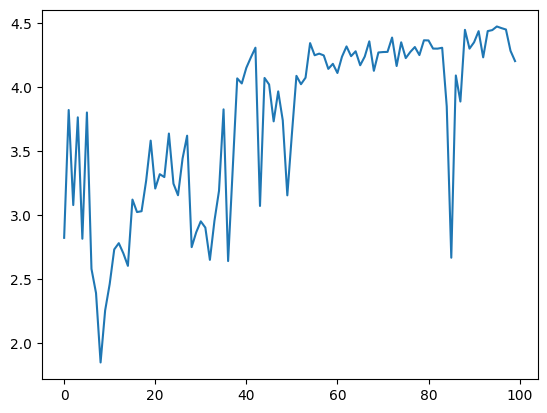

In [292]:
plt.plot(result_first)

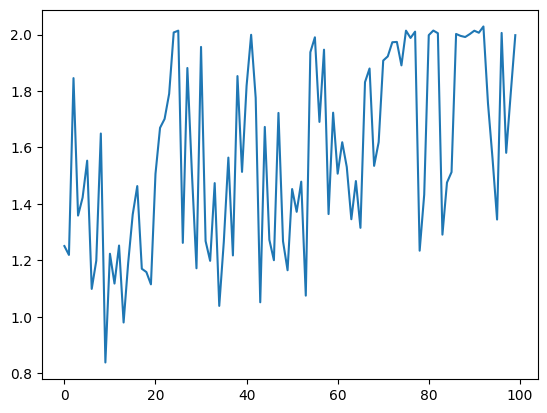

In [103]:
plt.plot(result_first)

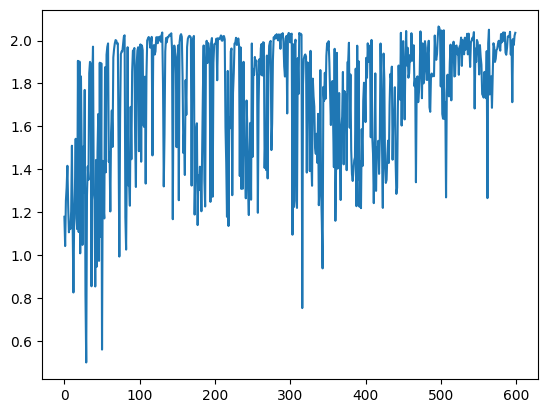

In [73]:
plt.plot(result_first)
# len(result_first)

In [293]:
test_architecture = AcesStepArchitectureEnv(14)
test_architecture.architecture.clusters

{0: [9, 10], 1: [3, 4], 2: [7, 8], 3: [0]}

In [75]:
# checkpoint_path = algorithm_first.save("./TFM/algorithms/10stations_600iter")

In [338]:
obs = test_architecture.reset()
test_architecture.architecture.round_robin()
print(test_architecture.architecture.compute_normalized_latency_dict())
print(test_architecture.architecture.compute_total_latency())
test_architecture.architecture.greedy_server()
print(test_architecture.architecture.compute_normalized_latency_dict())
print(test_architecture.architecture.compute_total_latency())
# test_architecture.architecture.greedy_algorithm()
# print(test_architecture.architecture.compute_normalized_latency_dict())
# print(test_architecture.architecture.compute_total_latency())
iteration = {}
allocation = []
types = []
for i in range(10):
    action = algorithm_first.compute_single_action(obs)
    output = test_architecture.step(action)
    obs = output[0]
    # print(output)
    type = output[3]['type']
    iteration[i] = output[1]
    if type==0:
        for i in range(12):
            allocation.append(action[i])
            types.append(0)
    elif type==1:
        for i in range(12):
            allocation.append(action[i])
            types.append(1)
    elif type==2:
        for i in range(12):
            allocation.append(action[i])
            types.append(2)
    else:
        for i in range(10):
            allocation.append(action[i])
            types.append(3)
    if output[2]:
        break

print(allocation)
print(types)
test_architecture.architecture.false_data_allocation = allocation
test_architecture.architecture.false_data_types = types
test_architecture.architecture.false_construct_dictionaries()
print(iteration)
print(test_architecture.architecture.false_compute_total_latency())

{0: 0.3207547169811321, 1: 0.3194706994328923, 2: 0.3194706994328923, 3: 0.600907029478458}
2872
{0: 0.5018867924528302, 1: 0.500945179584121, 2: 0.500945179584121, 3: 0.7732426303854876}
2048
[10, 9, 0, 1, 9, 10, 10, 0, 8, 1, 1, 10, 3, 2, 0, 4, 6, 4, 0, 4, 4, 0, 4, 5, 4, 0, 3, 4, 0, 0, 3, 0, 0, 4, 4, 4, 10, 11, 3, 1, 8, 1, 7, 8, 9, 1, 1, 10, 8, 1, 9, 0, 11, 9, 8, 9, 11, 8, 3, 11, 0, 3, 0, 6, 0, 0, 0, 2, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
{0: 0.6754716981132076, 1: 0.7509433962264151, 2: 0.7962264150943397, 3: 0.6, 4: 0.5622641509433962, 5: 0.8914027149321266, 6: 0.9547511312217195}
1266


In [270]:
len([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

80